In [1]:
import datetime
import duckdb
import numpy as np
import pandas as pd
import seaborn
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import tqdm

In [6]:
def load_dataset(path):
    with duckdb.connect(path, read_only=True) as con:
        df = con.sql("SELECT * FROM stocks ORDER BY stock, date").df()

    # only keep stocks that exist for the entire range
    all_dates = df.date.unique()
    stocks = {}

    # map each stock to a list of dates
    for i, row in df.iterrows():
        stocks.setdefault(row.stock, []).append(row.date)

    # filter all stocks that don't exist for all dates
    for stock, dates in stocks.items():
        if len(dates) < len(all_dates):
            df = df[df.stock != stock]

    # calculate the percent change for the day for every stock
    df['pct'] = (df.close - df.open) / df.open

    # return the dataset
    return df

training_dataset = load_dataset('sp500_2022.db')
validation_dataset = load_dataset('sp500_2023.db')

# get the unique set of stock names
stock_list = set(training_dataset.stock) & set(validation_dataset.stock)

# remove any stocks that aren't in both datasets
training_dataset = training_dataset[training_dataset.stock.isin(stock_list)]
validation_dataset = validation_dataset[validation_dataset.stock.isin(stock_list)]

# sort the stock list by name
stock_list = sorted(list(stock_list))

validation_dataset

,stock,date,open,high,low,close,volume,trade_count,vwap,pct
0,A,2023-01-03,151.96,153.1300,148.4700,150.04,1414284.0,28483.0,149.778426,-0.012635
1,A,2023-01-04,151.65,153.0400,150.2400,151.67,1247420.0,23065.0,151.814761,0.000132
2,A,2023-01-05,150.00,153.0700,148.7700,152.11,1714636.0,35551.0,151.657570,0.014067
3,A,2023-01-06,154.36,154.6400,143.0100,147.67,2444397.0,46812.0,146.516544,-0.043340
4,A,2023-01-09,149.69,151.2800,147.1980,147.47,1269574.0,29084.0,148.404346,-0.014831
...,...,...,...,...,...,...,...,...,...,...
125474,ZTS,2023-12-22,195.32,195.9100,192.7400,194.98,1548412.0,29540.0,194.474010,-0.001741
125475,ZTS,2023-12-26,194.88,196.3426,194.0900,195.50,814641.0,19369.0,195.486332,0.003181
125476,ZTS,2023-12-27,195.41,197.0100,194.7377,196.90,766411.0,16898.0,196.450034,0.007625
125477,ZTS,2023-12-28,197.62,198.6000,196.5300,197.16,880094.0,20530.0,197.275483,-0.002328


# Run on GPUs if possible

In [3]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# Define the Model

In [125]:
class StockModel(nn.Module):

    def __init__(self, stocks, target, window_size, dropout=0):
        super().__init__()

        # ensure the target stock is valid
        assert target in stocks, f'{target} is not a valid stock!'

        # which stock is being modeled
        self.stock = target

        # number of input features (stocks)
        self.input_size = len(stocks)

        # number of previous time stamps taken into account
        self.window_size = window_size

        # number of features in the last hidden state (number of time steps to predict)
        self.hidden_size = self.input_size // 2

        # number of stacked RNN cells
        self.num_layers = window_size

        # build the network
        #self.rnn = nn.RNN(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True, dropout=dropout)
        self.rnn = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True, dropout=dropout)
        self.lin = nn.Linear(self.hidden_size, 1)
        self.act = nn.Tanh()
    
    def forward(self, x):
        """
        Expected input shape: (num_batches, window_size, stock_features).
        """
        batch_size = x.size(0)

        # run the RNN/LSTM
        out, _ = self.rnn(x)

        # ensure the output shape is as expected
        assert out.shape == (batch_size, self.window_size, self.hidden_size)

        # for an RNN _ = hn
        # for an LSTM _ = (hn, cn)
        #
        # hn[-1, :, :] == out[:, -1, :]

        # get the hidden layer output of the final cell
        x = out[:, -1, :]

        # ensure it's the expected shape
        assert x.shape == (batch_size, self.hidden_size)
        
        # compress the output into a single stock prediction
        x = self.lin(x)
        x = self.act(x)

        return x

# Create Batches

In [126]:
def get_windows(dataset, window_size=10):
    """
    Returns a list of window dates from all dates available in a dataset.
    """
    dates = sorted(list(dataset.date.unique()))

    # create a sliding window of dates
    return [dates[i:i+window_size] for i in range(len(dates) - window_size*2)]

# returns a batch of input data for a window of dates
def get_inputs(dataset, window):
    """
    Returns a np.array of (window_size, stock_change) for a given window of dates.
    """
    stocks = dataset[dataset.date.isin(window)][['stock', 'date', 'pct']]

    # for each day in the window, get the pct changes sorted by stock symbol
    inputs = [stocks[stocks.date == day].sort_values('stock').pct for day in window]

    # convert each input into a numpy vector
    return np.vstack([np.array(i, dtype=np.float32) for i in inputs])

def get_prediction(dataset, stock, window, lag=1):
    """
    Returns an np.array of shape [1] with the predicted gain/loss of a stock `lag`
    days after a window.
    """
    pred_date = window[-1] + datetime.timedelta(days=lag)

    # get the first row from the dataset for the stock on (or after) pred_date
    df = dataset[(dataset.stock == stock) & (dataset.date >= pred_date)] \
        .sort_values('date') \
        .head(n=1)

    # get the prediction for that day
    return np.array(df.pct, dtype=np.float32)

def get_batches(dataset, stock, window_size=10, batch_size=5):
    """
    Returns a generator yielding (input_batch, prediction_batch).
    """
    windows = get_windows(dataset, window_size)

    # limit the windows to a multiple of batch_size
    windows = windows[:len(windows) - (len(windows) % batch_size)]

    # for each window, get the inputs and prediction
    inputs = [get_inputs(dataset, w) for w in windows]
    predictions = [get_prediction(dataset, stock, w) for w in windows]

    # create an array of indices to randomize the batches
    indices = np.arange(len(windows))
    np.random.shuffle(indices)

    # split the indices into batches
    batches = np.split(indices, len(windows) // batch_size)

    # yield each batch of inputs and predictions
    for batch in batches:
        batched_inputs = [inputs[i] for i in batch]
        batched_predictions = [predictions[i] for i in batch]

        yield (np.stack(batched_inputs), np.vstack(batched_predictions))

# Create a Model and Run Test Batch

In [127]:
# create a dummy model to validate batches
model = StockModel(stock_list, target=stock_list[0], window_size=10)

# create a test batch and run it through to confirm shapes
(test_inputs, test_prediction) = next(get_batches(training_dataset, model.stock, model.window_size, 5))

# ensure the inputs are the correct shape: (batch_size, window_size, num_stocks)
assert test_inputs.shape == (5, model.window_size, len(stock_list)), f'Input shape {test_inputs.shape} wrong!'

# run the input through the model
output = model(torch.from_numpy(test_inputs))

# the test_prediction should be the same shape as the output: (batch_size, 1)
assert output.shape == test_prediction.shape

# Train Model and Validate

In [128]:
def train_epoch(model, batch_size):
    """
    Train a single epoch for a target stock.
    """
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    running_loss = 0

    # generate all the batches for training
    training_batches = get_batches(training_dataset, model.stock, model.window_size, batch_size)

    # run training
    for (inputs, prediction) in training_batches:
        optimizer.zero_grad()

        # input and prediction tensors
        x = torch.from_numpy(inputs).to(device)
        y = torch.from_numpy(prediction).to(device)

        # run the model
        output = model(x)

        # calculate the loss
        loss = loss_fn(output, y)

        # run backpropogation
        loss.backward()
        optimizer.step()

        # calculate the running loss for the batch
        running_loss += loss.max().item()
    
    # TODO: run validation

    return running_loss

def train(model, num_epochs, batch_size):
    """
    Continue training a model for a target stock.
    """
    training_loss = [(i, train_epoch(model, batch_size)) for i in tqdm(range(num_epochs))]

    # create a dataframe tracking epoch and loss
    loss_df = pd.DataFrame(training_loss, columns=['epoch', 'loss'])
    
    # plot the loss
    return seaborn.lineplot(loss_df, x='epoch', y='loss')

# Create, Train, and Validate a Model

In [129]:
model = StockModel(stock_list, 'F', window_size=10)
model = model.to(device)

  0%|          | 0/50 [00:00<?, ?it/s]

<Axes: xlabel='epoch', ylabel='loss'>

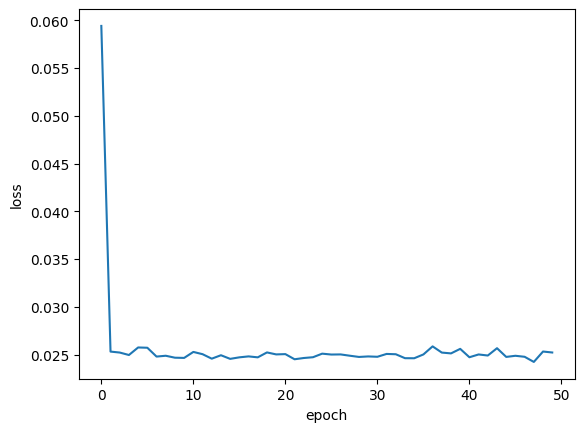

In [130]:
# train the model
train(model, num_epochs=50, batch_size=5)